Rata-rata intensitas: 132.43
Gamma yang disarankan: 0.97


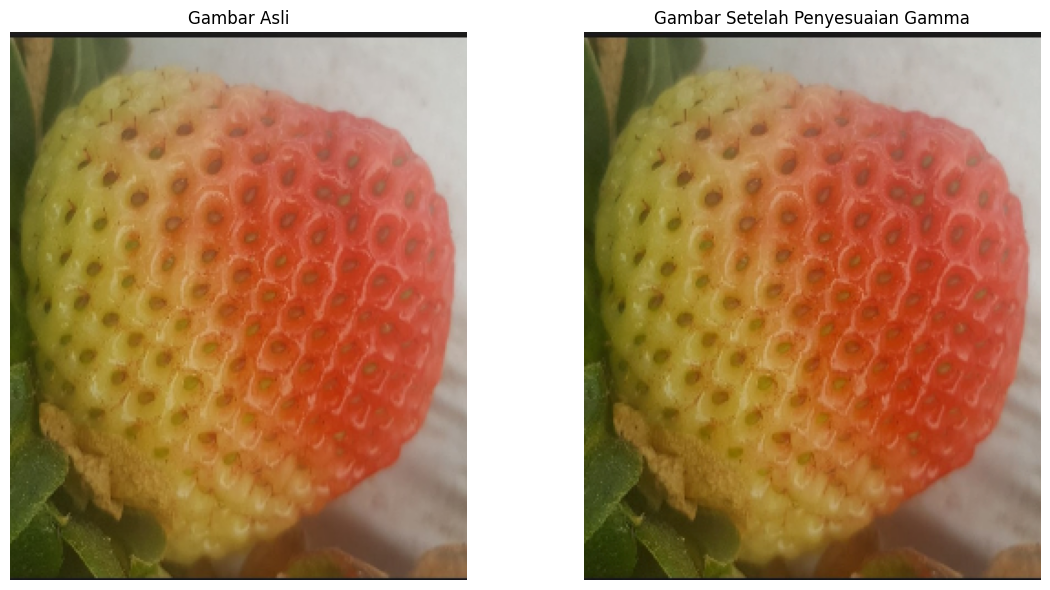

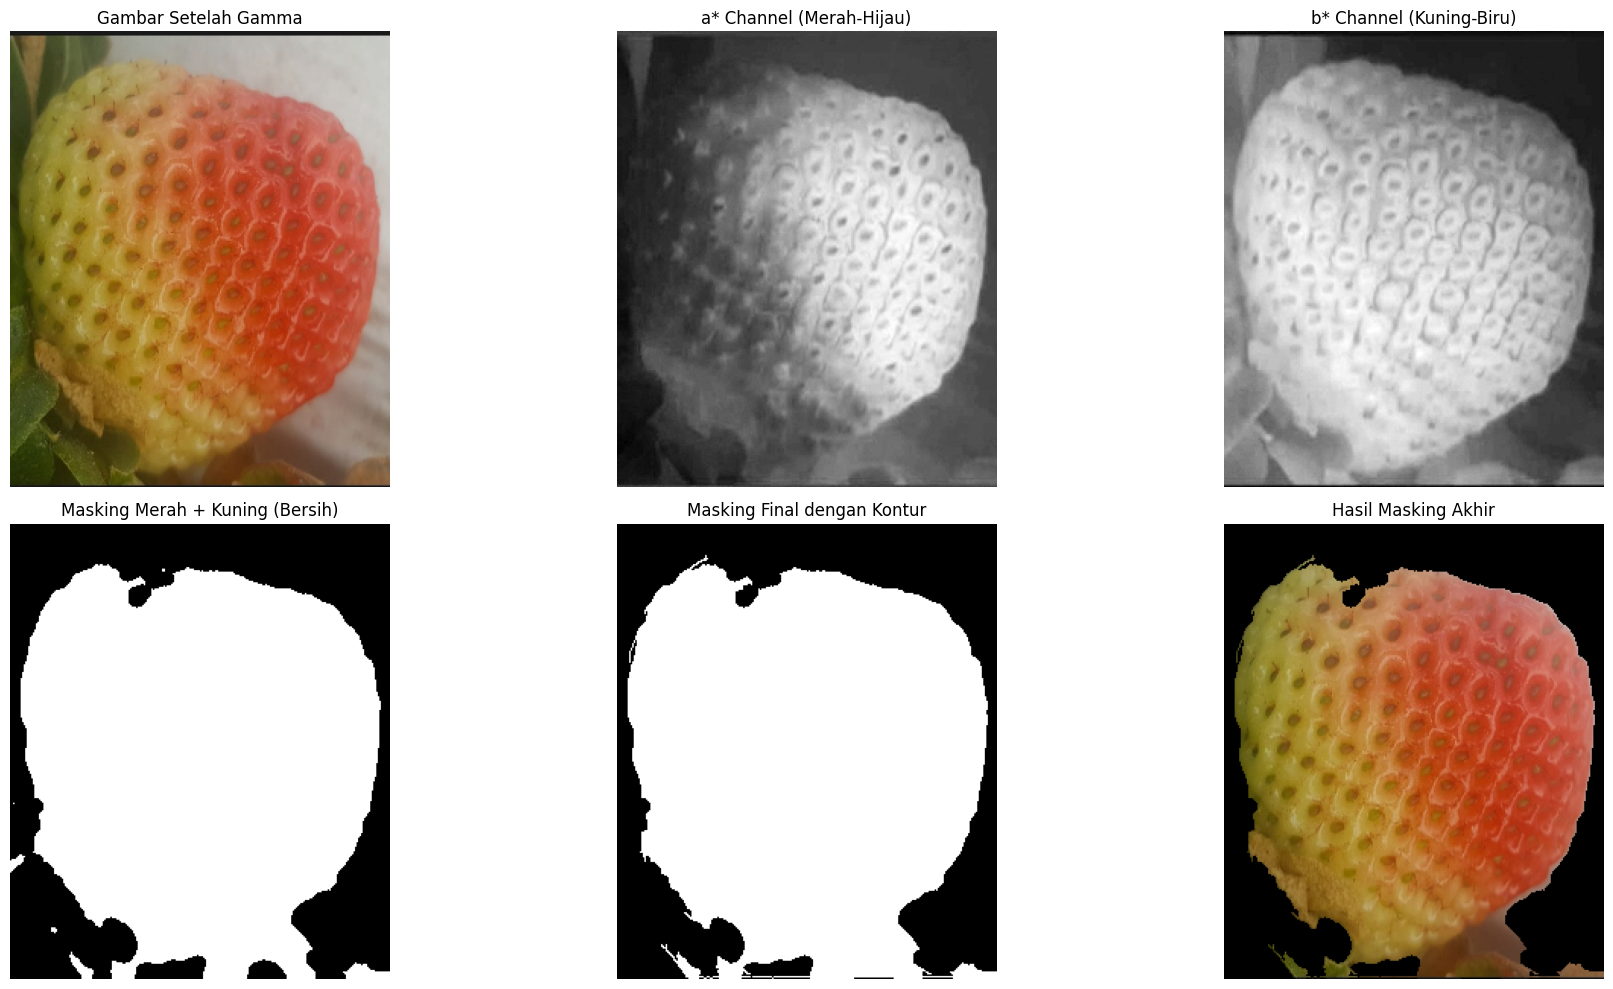

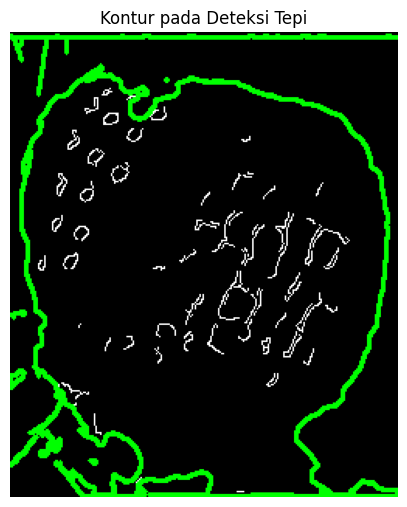

Luas masing-masing kontur buah strawberry (dalam piksel):
Buah 1: 0.50 piksel
Buah 2: 2.00 piksel
Buah 3: 12.00 piksel
Buah 4: 28.00 piksel
Buah 5: 11.00 piksel
Buah 6: 44.50 piksel
Buah 7: 0.00 piksel
Buah 8: 3.00 piksel
Buah 9: 1.00 piksel
Buah 10: 50739.50 piksel
Buah 11: 5.00 piksel

Total luas semua buah strawberry: 50846.50 piksel

----    Hasil Perhitungan    ----
Total luas semua buah strawberry : 50846.50 piksel
Luas area merah : 32197.00 piksel
Persentase kematangan : 63.32%


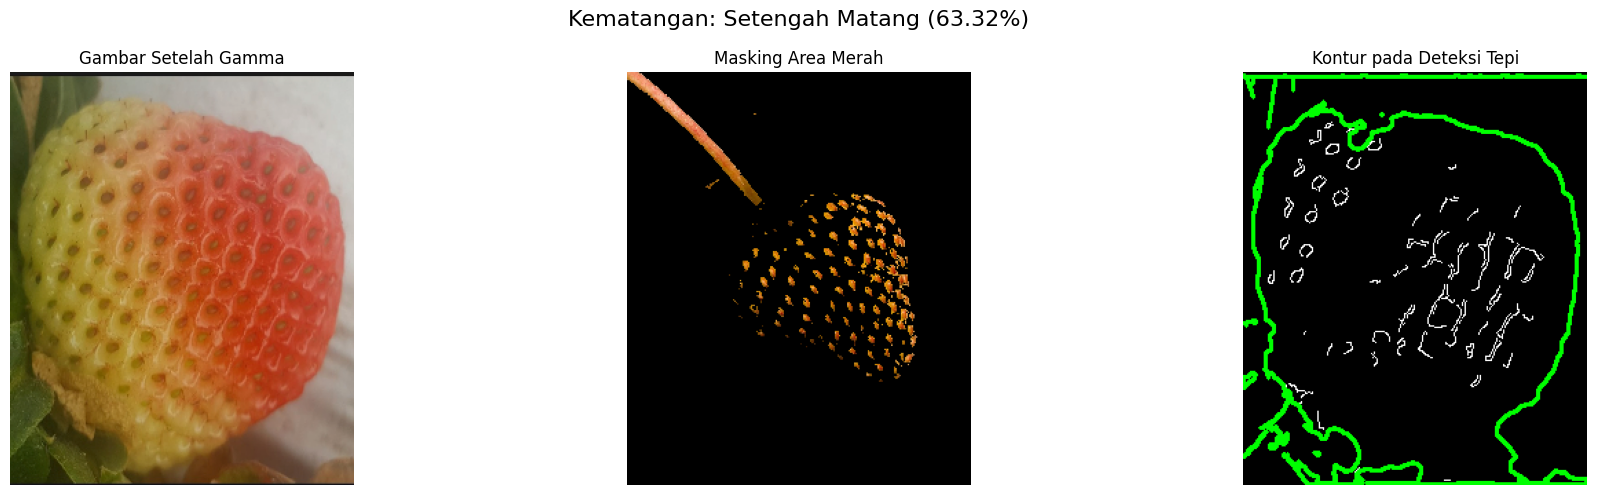

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path gambar
img_path = 'strawberry_setengah_matang.jpeg'
img = cv2.imread(img_path)

if img is None:
    print("Gagal memuat citra. Periksa path gambar.")
else:
    img = cv2.resize(img, (250, 300))

    def adjust_lightness(img_lab, gamma=1.0):
        """
        Menyesuaikan gamma hanya pada kanal L (lightness) di ruang warna LAB.
        """
        l_channel, a_channel, b_channel = cv2.split(img_lab)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        l_channel_adjusted = cv2.LUT(l_channel, table)
        img_lab_adjusted = cv2.merge((l_channel_adjusted, a_channel, b_channel))
        return img_lab_adjusted

    # Konversi ke LAB
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(img_lab)

    # Terapkan gamma otomatis
    mean_intensity = np.mean(l_channel)
    target_intensity = 128  # intensitas target
    gamma_suggested = target_intensity / mean_intensity

    # Batasi nilai gamma agar tidak terlalu ekstrem
    gamma_suggested = min(1, max(0.7, gamma_suggested))

    print(f"Rata-rata intensitas: {mean_intensity:.2f}")
    print(f"Gamma yang disarankan: {gamma_suggested:.2f}")

    # Terapkan penyesuaian gamma hanya pada kanal L
    img_lab_adjusted = adjust_lightness(img_lab, gamma=gamma_suggested)
    img_gamma = cv2.cvtColor(img_lab_adjusted, cv2.COLOR_LAB2BGR)

    # Masking warna merah berdasarkan kanal a*
    lower_red = 140
    upper_red = 210
    mask_red = cv2.inRange(a_channel, lower_red, upper_red)

    # Masking warna kuning berdasarkan kanal b*
    lower_yellow = 165
    upper_yellow = 200
    mask_yellow = cv2.inRange(b_channel, lower_yellow, upper_yellow)

    # Gabungkan masking merah dan kuning
    combined_mask = cv2.bitwise_or(mask_red, mask_yellow)

    # Operasi morfologi untuk membersihkan noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

    # Visualisasi hasil gamma
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Gambar Asli")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(img_gamma, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Gambar Setelah Penyesuaian Gamma")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Deteksi tepi menggunakan Canny
    gray = cv2.cvtColor(img_gamma, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    # Gabungkan hasil masking dengan deteksi tepi
    final_mask = cv2.bitwise_or(cleaned_mask, edges)

    # Threshold biner untuk mendeteksi kontur
    _, binary_img = cv2.threshold(final_mask, 127, 255, cv2.THRESH_BINARY)

    # Temukan kontur
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter kontur berdasarkan luas minimum
    min_area = 1000  # Luas minimum untuk menghindari deteksi kecil
    fruit_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Masking akhir berdasarkan kontur terdeteksi
    final_mask_contour = np.zeros_like(mask_red)
    cv2.drawContours(final_mask_contour, fruit_contours, -1, (255), thickness=cv2.FILLED)

    # Terapkan masking ke gambar asli
    result = cv2.bitwise_and(img_gamma, img_gamma, mask=final_mask_contour)

    # Visualisasi hasil
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    ax[0, 0].imshow(cv2.cvtColor(img_gamma, cv2.COLOR_BGR2RGB))
    ax[0, 0].set_title("Gambar Setelah Gamma")
    ax[0, 0].axis("off")

    ax[0, 1].imshow(a_channel, cmap="gray")
    ax[0, 1].set_title("a* Channel (Merah-Hijau)")
    ax[0, 1].axis("off")

    ax[0, 2].imshow(b_channel, cmap="gray")
    ax[0, 2].set_title("b* Channel (Kuning-Biru)")
    ax[0, 2].axis("off")

    ax[1, 0].imshow(cleaned_mask, cmap="gray")
    ax[1, 0].set_title("Masking Merah + Kuning (Bersih)")
    ax[1, 0].axis("off")

    ax[1, 1].imshow(final_mask_contour, cmap="gray")
    ax[1, 1].set_title("Masking Final dengan Kontur")
    ax[1, 1].axis("off")

    ax[1, 2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax[1, 2].set_title("Hasil Masking Akhir")
    ax[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # Hitung luas area kontur buah
    fruit_areas = [cv2.contourArea(cnt) for cnt in contours]
    total_area = sum(fruit_areas)

    # Visualize contours over the edge image
    edge_with_contours = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(edge_with_contours, contours, -1, (0, 255, 0), 2)

    # Display the result
    plt.figure(figsize=(5, 7))
    plt.imshow(cv2.cvtColor(edge_with_contours, cv2.COLOR_BGR2RGB))
    plt.title("Kontur pada Deteksi Tepi")
    plt.axis("off")
    plt.show()

    # Print area results
    print("Luas masing-masing kontur buah strawberry (dalam piksel):")
    for i, area in enumerate(fruit_areas, start=1):
        print(f"Buah {i}: {area:.2f} piksel")

    print(f"\nTotal luas semua buah strawberry: {total_area:.2f} piksel")

    # Hitung luas area merah pada mask_red
    mask_red_contour = cv2.bitwise_and(mask_red, mask_red, mask=final_mask_contour)
    red_area = cv2.countNonZero(mask_red_contour)

    # Hitung persentase kematangan
    maturity_percentage = (red_area / total_area) * 100 if total_area > 0 else 0.0

    # Tampilkan hasil luas area dan persentase kematangan
    print(f"\n----    Hasil Perhitungan    ----")
    print(f"Total luas semua buah strawberry : {total_area:.2f} piksel")
    print(f"Luas area merah : {red_area:.2f} piksel")
    print(f"Persentase kematangan : {maturity_percentage:.2f}%")

    # Klasifikasi kematangan
    if maturity_percentage >= 80:
        maturity_status = "Matang"
    elif 20 < maturity_percentage < 80:
        maturity_status = "Setengah Matang"
    else:
        maturity_status = "Mentah"

    # Visualisasi hasil
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(cv2.cvtColor(img_gamma, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Gambar Setelah Gamma")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(masked_red_area, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Masking Area Merah")
    ax[1].axis("off")

    ax[2].imshow(cv2.cvtColor(edge_with_contours, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Kontur pada Deteksi Tepi")
    ax[2].axis("off")

    plt.suptitle(f"Kematangan: {maturity_status} ({maturity_percentage:.2f}%)", fontsize=16)
    plt.tight_layout()
    plt.show()
